# What Determines How Much I Drive?

In [1]:
# pip install chowtest

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from chow_test import chowtest
import statsmodels.api as sm 
import math
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999 # to display all rows
pd.options.display.max_columns = 999 # to display all columns

### Import Data

In [23]:
miles_df = pd.read_csv("Data/Mileage.csv", engine = "python")
miles_df.set_index('Monday',inplace=True)
miles_df.index = pd.to_datetime(miles_df.index)

In [4]:
miles_df

,Mileage,Notes
Monday,,
2019-08-19,293.8,NaN
2019-08-26,955.0,Milwaukee
2019-09-02,167.8,NaN
2019-09-09,411.4,La Crosse
2019-09-16,958.9,Chicago
2019-09-23,87.0,NaN
2019-09-30,130.1,NaN
2019-10-07,1007.5,Chicago
2019-10-14,88.3,NaN


In [5]:
miles_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2019-08-19 to 2020-12-14
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Mileage  69 non-null     float64
 1   Notes    12 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


### Idenity week(s) where mileage was not recorded

In [6]:
miles_df[miles_df["Mileage"].isnull()]

,Mileage,Notes
Monday,,
2020-03-09,NaN,Car battery died


### How should the missing value be imputed?

In [7]:
miles_df.describe()

,Mileage
count,69.000000
mean,169.723188
std,244.174248
min,0.000000
25%,44.700000
50%,87.000000
75%,150.400000
max,1007.500000


Should we use the global mean mean, global median, or perhaps something more specific?

Let investigate a more specific value to impute the missing value.

In [8]:
miles_df.loc[:,"Notes"].unique()

array([nan, 'Milwaukee', 'La Crosse', 'Chicago', 'Car battery died',
       'Milwaukee; Coronavirus begins, 3/11 NBA postponed season',
       'Redwood Falls and Mankato', 'Winona', 'Mankato'], dtype=object)

In [24]:
# identify when travel occurred; notes only exist for travels outside metro area
miles_df["travel_ind"] = np.where(miles_df['Notes'].notnull(), 1, 0)

# car battery died and no travel occurred
miles_df["travel_ind"] = np.where(miles_df['Notes'].str.lower().str.contains("car battery", na = False), 
                                   0, miles_df["travel_ind"])

Looks like I traveled to Chicago 5 times during this time period. 

In [25]:
miles_df.groupby(["Notes"]).agg({"travel_ind":"sum"}).sort_values("travel_ind", ascending = False)

,travel_ind
Notes,
Chicago,5
La Crosse,1
Mankato,1
Milwaukee,1
"Milwaukee; Coronavirus begins, 3/11 NBA postponed season",1
Redwood Falls and Mankato,1
Winona,1
Car battery died,0


Group by `travel_ind` and get average mileage in order to see a more specific value that may be more suitable for the period containing the missing value. 

In [26]:
grouped_df = miles_df.groupby(["travel_ind"]).agg({"Mileage":["count","mean","median"]})
grouped_df

Mileage                   
             count        mean median
travel_ind                           
0               58   87.389655   73.8
1               11  603.845455  411.4

Imputing values is more of an art than a science. Because this is a time series, we want to try to retain as many observations as possible. Because the median of the series is 87 miles, and the mean of the group of weeks where I didn't travel is about 87 miles, we can feel comfortable imputing a value of approximately 87 for the missing value. 

It won't always be this conclusive when imputing values and reducing bias in the observations, but because the overall median is similar to the mean during non-traveling weeks, the solution is appropriate.  

In [27]:
# exclude first level of multi-indexed columns resulting from the groupby
grouped_df.columns = grouped_df.columns.droplevel(0)

# get the number to impute the null value in Mileage
non_travel_mean_mileage = grouped_df.loc[0, "mean"].round(1)
non_travel_mean_mileage

87.4

### Impute missing mileage value

In [30]:
miles_df.loc[pd.to_datetime(['2020-03-09'])]

,Mileage,Notes,travel_ind
2020-03-09,87.4,Car battery died,0


In [31]:
miles_df["Mileage"] = np.where(miles_df["Mileage"].isnull(), non_travel_mean_mileage, miles_df["Mileage"]).round(1)

miles_df.loc[pd.to_datetime(['2020-03-09'])]

,Mileage,Notes,travel_ind
2020-03-09,87.4,Car battery died,0


Mileage field is ready to be used.

### Histogram of Mileage

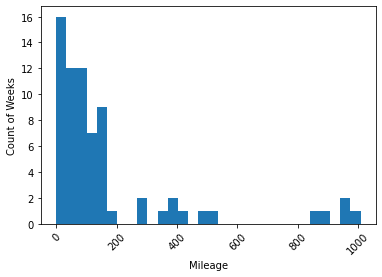

In [34]:
plt.hist(miles_df["Mileage"], density = False, bins = 30)
plt.ylabel("Count of Weeks")
plt.xlabel("Mileage")
plt.xticks(rotation = 45)
plt.show()

### Trend over Time

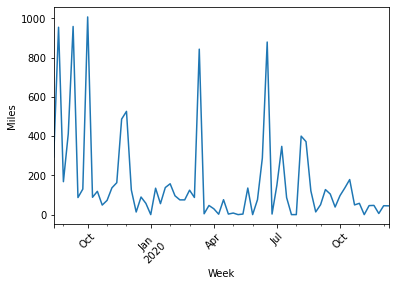

In [35]:
miles_df["Mileage"].plot()
plt.ylabel("Miles")
plt.xlabel("Week")
plt.xticks(rotation = 45)
plt.show()

If a trend exists, then the series is not stationary, and will require differencing, at least a difference order of 1.  
The series appears to be stationary. We will verify stationarity using a statistical test below. 

We will take the natural log of the `Mileage` series because the histogram shows a right-skew in the data. 

We also add 1 to the level of the Mileage series because log(0) cannot be taken (log(0) = inf). All values are scaled by 1 so this shouldn't affect the analysis too much. This analysis is for practicing with time series data, and scaling may not be appropriate in othet applications.

In [39]:
# can't take log of 0, so offset Mileage by 2 miles
miles_df["Mileage_log"] = np.log(miles_df["Mileage"] + 1)
# miles_df["Mileage"] = miles_df["Mileage"]+1

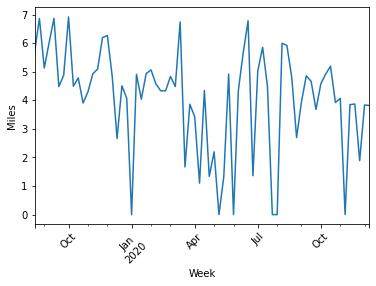

In [40]:
miles_df["Mileage_log"].plot()
plt.ylabel("Miles")
plt.xlabel("Week")
plt.xticks(rotation = 45)
plt.show()

### Testing Stationarity

The mean of the series should not be a function of time; its mean should not drift over time. The variance of the series should also not be a function of time; its variance should not expand/contract over time (homoskedasticity = variance is not a function of time).

To help identify if the time series needs to be differenced or not, we will check the rolling mean, Augemented Dickey-Fuller (ADF) test, and KPSS test. 

Looking at the rolling mean and standard deviation, the series appears to be stationary. There seems to be a decrease in driving in the spring and early summar of 2020, coinciding with the start Covid-19 pandemic, as defined for this analysis. However, the rolling mean and standard deviation seem to rebound over time. This supports the hypothesis that the series is stationary. 

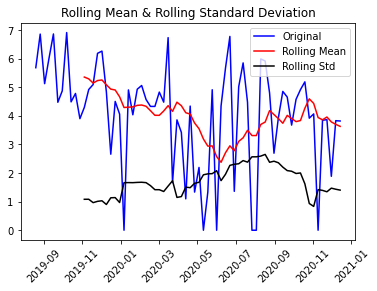

In [47]:
# check rolling mean (the eye test)  
rolling_mean = miles_df[["Mileage_log"]].rolling(window = 12).mean()
rolling_std = miles_df[["Mileage_log"]].rolling(window = 12).std()
plt.plot(miles_df[["Mileage_log"]], color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.xticks(rotation = 45)
plt.show()

ADF
- Null hypothesis: Unit root exists (Series is non-stationary)
- Alternative hypothesis: Series is stationary

The ADF-statistic is high and the associated p-value is low, leading us to reject the null hypothesis at the 5% level of significance and conclude the series is stationary.

In [50]:
# ADF Test
adf_result_log = adfuller(miles_df['Mileage_log'], autolag = 'AIC')  
print("1. ADF : ", "\t\t\t\t\t\t", adf_result_log[0])  
print("2. P-Value : ", "\t\t\t\t\t\t", adf_result_log[1])
print("3. Num Of Lags : ", "\t\t\t\t\t", adf_result_log[2])
print("4. Num Of Observations Used For ADF Regression:", "\t", adf_result_log[3])
print("5. Critical Values :")
for key, val in adf_result_log[4].items():
    print("\t",key, ": ", val)

1. ADF :  						 -6.578755034953513
2. P-Value :  						 7.60761237317162e-09
3. Num Of Lags :  					 0
4. Num Of Observations Used For ADF Regression: 	 69
5. Critical Values :
	 1% :  -3.528889992207215
	 5% :  -2.9044395987933362
	 10% :  -2.589655654274312


KPSS
- Null hypothesis: Series is stationary
- Alternative hypothesis: Unit root exists (Series is non-stationary)

The KPSS-statistic is high and the associated p-value is low, leading us to fail to reject the null hypothesis at the 5% level of significance and conclude the series is stationary.

We may be a little concerned that the KPSS test is statistically significant at the 10% level, however, we feel comfortable conluding the time series is stationary because of the tests and analyses above indicating a stationary series. 

In [55]:
# KPSS Test
kpss_result_log = kpss(miles_df["Mileage_log"].values, regression='c', lags = "legacy")
print('\nKPSS Statistic: \t %f' % kpss_result_log[0])
print('p-value: \t\t %f' % kpss_result_log[1])
for key, value in kpss_result_log[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 	 0.388044
p-value: 		 0.082308
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


### Analyzing Autocorrelation and Moving Average

Let's look at the Partial Autocorrelation and Autocorrelation charts. The Partial Autocorrelation chart helps identify if any lag terms need to be included in the time series model.The Autocorrelation chart helps identify if any moving average terms need to be included in the time series model.

It seems that lag1 and lag14 may be statistically important to include in the model. 14 weeks back seems irrelevant to determining how much one drives. We will include and analyze lag1 in the time series model.  

No moving average terms seem to be statistically important to include in the model. 

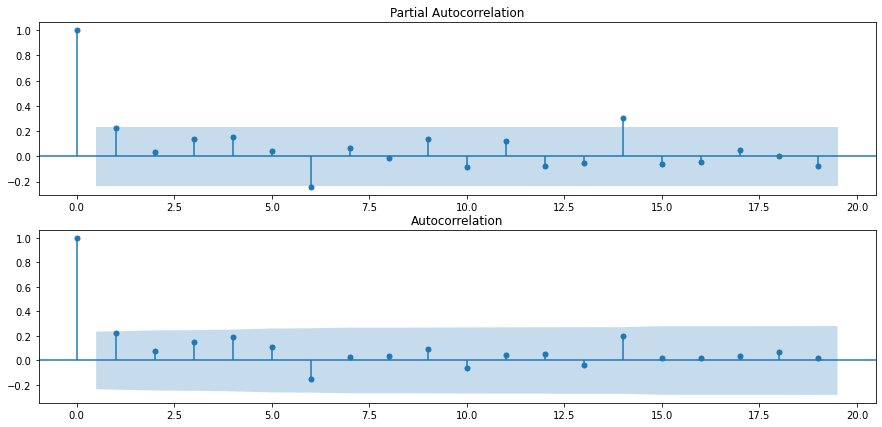

In [56]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
fig = plot_pacf(miles_df['Mileage_log'], ax=ax1) # AR
ax2 = fig.add_subplot(212)
fig = plot_acf(miles_df['Mileage_log'], ax=ax2) # MA

### Split into Train and Test Datasets

In [65]:
# test period will be last 10 observations  
train_df = miles_df.iloc[:-10]  
test_df = miles_df.iloc[-10:]

print("Original dataset shape", miles_df.shape)
print("Train shape:", train_df.shape) 
print("Test shape:", test_df.shape)

Original dataset shape (70, 4)
Train shape: (60, 4)
Test shape: (10, 4)


In [66]:
train_df.tail(2)

,Mileage,Notes,travel_ind,Mileage_log
Monday,,,,
2020-09-28,38.6,NaN,0,3.678829
2020-10-05,96.5,NaN,0,4.579852


In [67]:
test_df.head(2)

,Mileage,Notes,travel_ind,Mileage_log
Monday,,,,
2020-10-12,136.0,NaN,0,4.919981
2020-10-19,178.7,Mankato,1,5.191289


### ARIMA

/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                Mileage   No. Observations:                   60
Model:                          ARIMA   Log Likelihood                -417.590
Date:                Thu, 28 Jan 2021   AIC                            839.180
Time:                        13:26:52   BIC                            843.369
Sample:                    08-19-2019   HQIC                           840.818
                         - 10-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        187.4717     74.114      2.529      0.011      42.210     332.733
sigma2      6.501e+04   1.63e+04      3.999      0.000    3.31e+04    9.69e+04
Ljung-Box (L1) (Q):                   0.60   Jarque-

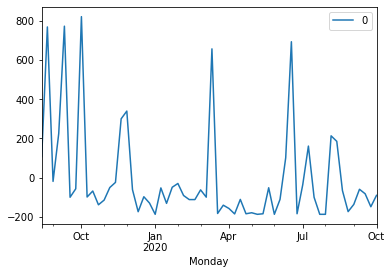

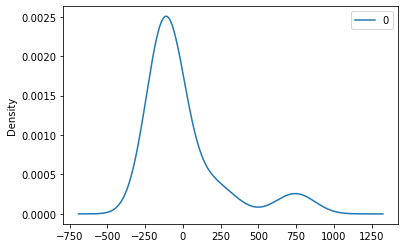

                0
count   60.000000
mean     0.000005
std    257.056886
min   -186.471661
25%   -141.946661
50%    -93.721661
75%    -27.896661
max    821.028339


In [31]:
# fit model  
model = ARIMA(train_df["Mileage"], order=(0,0,0))
model_fit = model.fit()
# # summary of fit model  
print(model_fit.summary())
# # line plot of residuals  
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()  
plt.show()
# # density plot of residuals  
residuals.plot(kind='kde')  
plt.show()  

# summary stats of residuals  
print(residuals.describe())  

# prediction  
#     - "We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the typ argument to the value ‘levels’: typ=’levels’."
#     - can also use forecast()  
#         `output = model_fit.forecast()`  
#         `yhat = output[0]`

In [ ]:
# # fit model  
# model = ARIMA(train_df["Mileage_log"], order=(0,0,0))  
# model_fit = model.fit()  
# plt.plot(train_df["Mileage_log"])
# plt.plot(model_fit.fittedvalues, color='red') 

# # in-sample prediction  
# predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
# predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# predictions_ARIMA_log = pd.Series(train_df["Mileage"].iloc[0], index=train_df.index)
# predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
# predictions_ARIMA = np.exp(predictions_ARIMA_log)
# plt.plot(predictions_ARIMA)  
# # #  out-of-sample prediction  
# model_fit.plot_predict(1,264)

/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                Mileage   No. Observations:                   60
Model:                          ARIMA   Log Likelihood                -417.590
Date:                Thu, 28 Jan 2021   AIC                            839.180
Time:                        13:26:53   BIC                            843.369
Sample:                    08-19-2019   HQIC                           840.818
                         - 10-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        187.4717     74.114      2.529      0.011      42.210     332.733
sigma2      6.501e+04   1.63e+04      3.999      0.000    3.31e+04    9.69e+04
Ljung-Box (L1) (Q):                   0.60   Jarque-

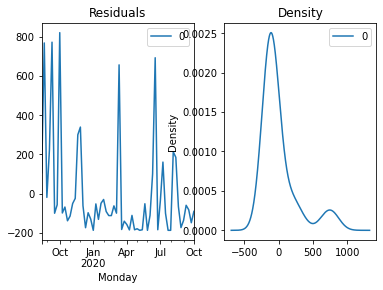

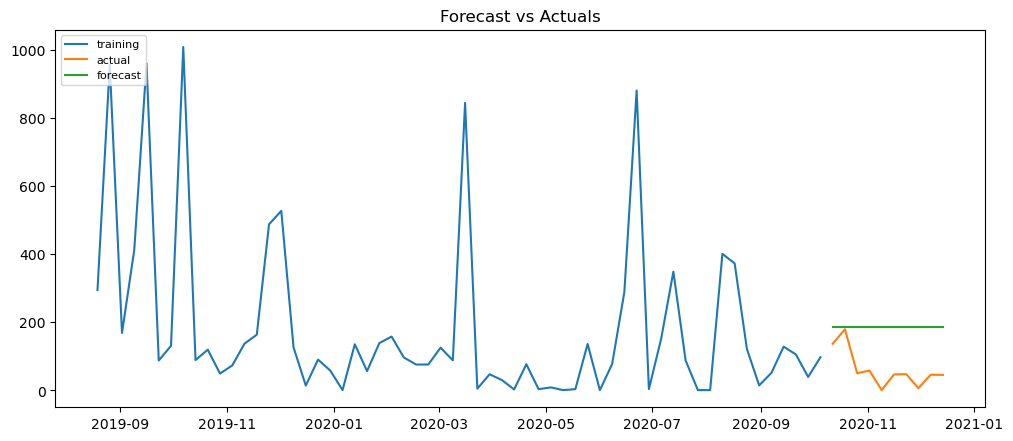

In [32]:
# 1,1,2 ARIMA Model  
model = ARIMA(train_df["Mileage"], order=(0,0,0))  
model_fit = model.fit()
print(model_fit.summary())

# Plot residual errors  
residuals = pd.DataFrame(model_fit.resid) 
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0]) 
residuals.plot(kind='kde', title='Density', ax=ax[1])  
plt.show() 

# Forecast  
# fc, se, conf = model_fit.forecast(15, alpha=0.05)  # 95% conf`  
fc = model_fit.forecast(10, alpha=0.05)  # 95% conf`  

# Make as pandas series  
fc_series = pd.Series(fc, index=test_df.index)


# Plot  
plt.figure(figsize=(12,5), dpi=100)  
plt.plot(train_df["Mileage"], label='training')
plt.plot(test_df["Mileage"], label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:            Mileage_log   No. Observations:                   60
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -115.191
Date:                Thu, 28 Jan 2021   AIC                            236.382
Time:                        13:26:57   BIC                            242.665
Sample:                    08-19-2019   HQIC                           238.840
                         - 10-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2623      0.331     12.862      0.000       3.613       4.912
ar.L1          0.2326      0.117      1.983      0.047       0.003       0.463
sigma2         2.7207      0.630      4.322      0.0

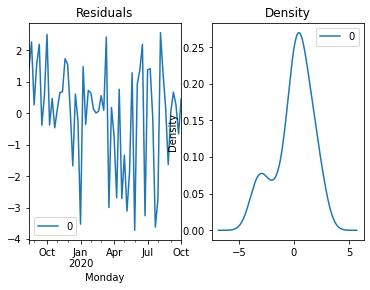

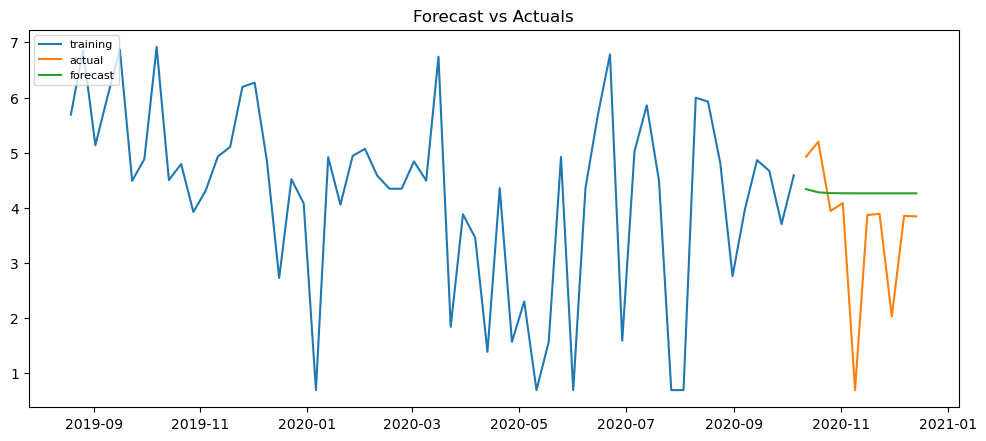

In [33]:
# 1,1,2 ARIMA Model  
model = ARIMA(train_df["Mileage_log"], order=(1,0,0))  
model_fit = model.fit()
print(model_fit.summary())

# Plot residual errors  
residuals = pd.DataFrame(model_fit.resid) 
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0]) 
residuals.plot(kind='kde', title='Density', ax=ax[1])  
plt.show() 

# Forecast  
# fc, se, conf = model_fit.forecast(15, alpha=0.05)  # 95% conf`  
fc_log = model_fit.forecast(10, alpha=0.05)  # 95% conf`  

# Make as pandas series  
# fc_series = pd.Series(fc, index=test_df.index)
fc_series = pd.Series(fc_log)


# Plot  
plt.figure(figsize=(12,5), dpi=100)  
plt.plot(train_df["Mileage_log"], label='training')
plt.plot(test_df["Mileage_log"], label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Forecasting Metrics

In [34]:
def performance_metrics(predicted, actual):
    mape = np.mean(np.abs(predicted - actual)/np.abs(actual))*100  # MAPE 
    me = np.mean(predicted - actual)             # ME
    mae = np.mean(np.abs(predicted - actual))    # MAE
    mpe = np.mean((predicted - actual)/actual)*100   # MPE
    rmse = np.mean((predicted - actual)**2)**.5  # RMSE
    corr = np.corrcoef(predicted, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([predicted[:,None], actual[:,None]]), axis=1) 
#     maxs = np.amax(np.hstack([predicted[:,None], actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 
            'me':me,
            'mae': mae,
            'mpe': mpe, 
            'rmse':rmse, 
            'corr':corr})  

# forecast_accuracy(fc, test.values) 

In [35]:
performance_metrics(fc, test_df["Mileage"])

/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


{'mape': 2312.761961877445,
 'me': 125.471661216272,
 'mae': 125.471661216272,
 'mpe': 2312.761961877445,
 'rmse': 135.93619006125974,
 'corr': nan}

In [36]:
performance_metrics(fc_log, test_df["Mileage_log"])

{'mape': 70.85023039827439,
 'me': 0.6392664993487767,
 'mae': 0.9403614208573897,
 'mpe': 64.9324631411319,
 'rmse': 1.4032596586564834,
 'corr': 0.4457414498875893}

### Create Destination Indicators

In [37]:
# miles_df["Milwaukee"] = np.where(miles_df['Notes'].str.lower().str.contains("milwaukee", na = False), 1, 0)
# miles_df["Chicago"] = np.where(miles_df['Notes'].str.lower().str.contains("chicago", na = False), 1, 0)

### Identifying when Coronovirus started

In [38]:
miles_df.loc[miles_df['Notes'].str.lower().str.contains("coronavirus", na = False)]

,Mileage,Notes,travel_ind,Mileage_log,Milwaukee,Chicago
Monday,,,,,,
2020-03-16,844.3,"Milwaukee; Coronavirus begins, 3/11 NBA postpo...",1,6.739692,1,0


### Chow Breakpoint Test

test whether one regression or two or more regressions best characterise the data. 

test is capable of detecting "structural breaks" within time-series

In [39]:
chowtest(y = miles_df[["Mileage"]],
         X = miles_df[["travel_ind"]],
         last_index_in_model_1 = "2020-03-09",
         first_index_in_model_2 = "2020-03-16",
         significance_level = 0.05)

****************************************************************************************************
Reject the null hypothesis of equality of regression coefficients in the 2 periods.
****************************************************************************************************
Chow Statistic: 12.752858942889294 p value: 0.0
****************************************************************************************************


(12.752858942889294, 1.1116191744875437e-08)

In [40]:
chowtest(y = miles_df[["Mileage"]],
         X = miles_df[["travel_ind","Milwaukee","Chicago"]],
         last_index_in_model_1 = "2020-03-09",
         first_index_in_model_2 = "2020-03-16",
         significance_level = 0.05)

****************************************************************************************************
Reject the null hypothesis of equality of regression coefficients in the 2 periods.
****************************************************************************************************
Chow Statistic: 8.786592900213678 p value: 0.0
****************************************************************************************************


(8.786592900213678, 2.411714624450667e-06)

### Create Covid Indicator in Training Dataset

In [79]:
# create indicator for Coronavirus period vs non-Coronavirus period
train_df["covid_ind"] = np.where(train_df.index >= "2020-03-16", 1, 0)
print(train_df.groupby(["covid_ind"]).agg({"Mileage":["count","mean","median"]}), "\n")

test_df["covid_ind"] = np.where(test_df.index >= "2020-03-16", 1, 0)
print("\n", test_df.groupby(["covid_ind"]).agg({"Mileage":["count","mean","median"]}))

          Mileage                    
            count        mean  median
covid_ind                            
0              30  230.366667  126.05
1              30  144.576667   64.25 


           Mileage             
            count  mean median
covid_ind                     
1              10  62.0   47.4


In [64]:
train_df.head()

,Mileage,Notes,travel_ind,Mileage_log,covid_ind
Monday,,,,,
2019-08-19,294.8,NaN,0,5.689684,0
2019-08-26,956.0,Milwaukee,1,6.863803,0
2019-09-02,168.8,NaN,0,5.134621,0
2019-09-09,412.4,La Crosse,1,6.024416,0
2019-09-16,959.9,Chicago,1,6.867870,0


In [65]:
train_df.tail()

,Mileage,Notes,travel_ind,Mileage_log,covid_ind
Monday,,,,,
2020-09-07,51.5,NaN,0,3.960813,1
2020-09-14,128.6,NaN,0,4.864453,1
2020-09-21,105.7,NaN,0,4.670021,1
2020-09-28,39.6,NaN,0,3.703768,1
2020-10-05,97.5,NaN,0,4.590057,1


In [92]:
test_df

,Mileage,Notes,travel_ind,Mileage_log,covid_ind
Monday,,,,,
2020-10-12,137.0,NaN,0,4.927254,1
2020-10-19,179.7,Mankato,1,5.196838,1
2020-10-26,50.5,NaN,0,3.941582,1
2020-11-02,58.5,NaN,0,4.085976,1
2020-11-09,1.0,NaN,0,0.693147,1
2020-11-16,46.9,NaN,0,3.869116,1
2020-11-23,47.9,NaN,0,3.889777,1
2020-11-30,6.6,NaN,0,2.028148,1
2020-12-07,46.2,NaN,0,3.854394,1


### OLS with exogenous features and no lag

In [125]:
train_x = train_df[["travel_ind","covid_ind"]]
train_y = train_df[["Mileage_log"]]

In [126]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(train_x)
model = sm.OLS(train_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Mileage_log   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     25.23
Date:                Thu, 28 Jan 2021   Prob (F-statistic):           1.42e-08
Time:                        14:42:51   Log-Likelihood:                -97.847
No. Observations:                  60   AIC:                             201.7
Df Residuals:                      57   BIC:                             208.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4857      0.239     18.779      0.000       4.007       4.964
travel_ind     2.6966      0.441      6.114      0.000       1.813       3.580
covid_ind     -1.3634      0.329     -4.148      0.000      -2.022      -0.705
==============================================================================
Omnibus:                        6.768   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.064
Skew:                          -0.758   Prob(JB):                       0.0482
Kurtosis:                       3.361   Cond. No.                         3.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mileage is not normally distributed, as expected. I don't regularly travel long distance. Further, driving less during the covid pandemic skews the istribution further. A non-normal distribution makes it harder to capture the pattern in weekly mileage. This is the nature of the data and what we want to explore in the first place, not statistically correct it.

DB-stat

null hypothesis that the errors are serially uncorrelated against the alternative that they follow a first order autoregressive process

In [ ]:
plt.hist(miles_df["Mileage"], density = False, bins = 20)
plt.ylabel("Count")
plt.xlabel("Miles")
plt.xticks(rotation = 45)
plt.show()

In [ ]:
plt.hist(miles_df["Mileage"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Miles")
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

In [ ]:
miles_df["Mileage"].plot()
plt.show()

### OLS with exogenous features with lag1

In [118]:
train_df["Mileage_log_lag1"] = train_df["Mileage_log"].shift(1)
train_df2 = train_df[["Mileage_log","Mileage_log_lag1","travel_ind","covid_ind"]].dropna()

In [120]:
train_x = train_df2[["travel_ind","covid_ind","Mileage_log_lag1"]]
train_y = train_df2[["Mileage_log"]]

In [121]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(train_x)
model = sm.OLS(train_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Mileage_log   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     16.39
Date:                Thu, 28 Jan 2021   Prob (F-statistic):           9.91e-08
Time:                        14:38:27   Log-Likelihood:                -96.215
No. Observations:                  59   AIC:                             200.4
Df Residuals:                      55   BIC:                             208.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.3761      0.559      7.824      0.000       3.255       5.497
travel_ind           2.7058      0.454      5.964      0.000       1.797       3.615
covid_ind           -1.3060      0.360     -3.631      0.001      -2.027      -0.585
Mileage_log_lag1     0.0138      0.106      0.130      0.897      -0.198       0.226
==============================================================================
Omnibus:                        6.399   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                5.690
Skew:                          -0.744   Prob(JB):                       0.0581
Kurtosis:                       3.318   Cond. No.                         17.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""